# Data processing 
This notebook is intended to work through the whole data processing
pipeline, making all the corrections to the observed travel times such
that we can try to invert for CMB topography. We'll need access to all
the tools, so do something like this before starting:

    export PYTHONPATH="../tools:../:../tools/packages/lib/python/:../tools/tomocorr"
    
(and make sure you can run the other notebooks

In [1]:
# Environment setup - quite a lot here

# Make pictures show up in the web browser,
# import matplotlib etc, and make the figures
# big
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
plt.rcParams['figure.figsize'] = (12, 8)

# Other "standard" modules
import pandas
import numpy as np

# Get access to taup
import obspy.taup

# Geodesic calculations
import geographiclib.geodesic as geod

# Our ISC parser
import read_ISC

# tomographic correction
import tomocorr2

# Our ellipticity corrections
import ellippy

## Read and plot data
Here we read in the EQ data and load it into
a Pandas dataframe. We then calculate travel
times and store these in seconds (not deltatime
objects).

In [2]:
all_picks = read_ISC.read_picks('../data/ISC_Jan_2012_trim.dat', ('P', 'PcP'))
paired_picks = read_ISC.pair_picks(all_picks, 'PcP', 'P')

# Put in a dataframe
paired_picks_df = pandas.DataFrame.from_dict(paired_picks, orient='index')

# Remove Pdiff
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance < 80)]

# Remove P triplications
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance > 30)]

# Calculate PcP and P travel time (and store as a real in seconds)
paired_picks_df["PcP_ttime"] = (paired_picks_df.PcP_datetime - 
                                paired_picks_df.event_datetime).values / np.timedelta64(1, 's')
paired_picks_df["P_ttime"] = (paired_picks_df.P_datetime - 
                              paired_picks_df.event_datetime).values / np.timedelta64(1, 's')


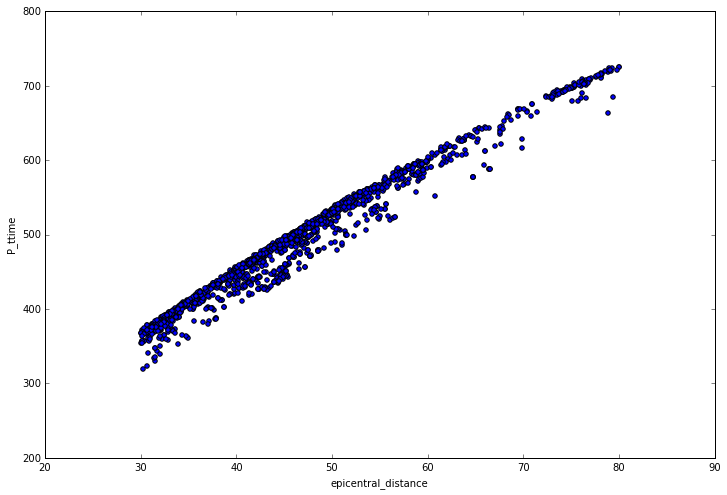

In [3]:
# Plot P travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='P_ttime')

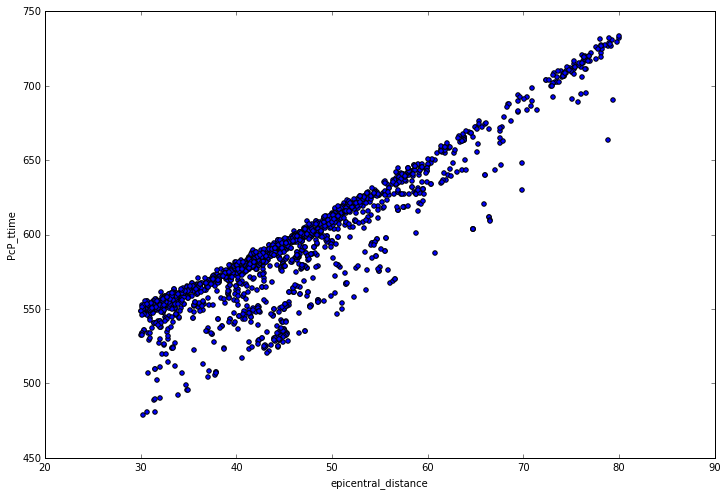

In [4]:
# Plot PcP travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_ttime')

## Bounce points on the CMB
We'll use a 1D model to work out the bounce points for
PcP on the CMB and add these to the dataframe. We can
then use these to plot data geographically.

In [5]:
# We need a taup model that knows about 
# location. We've got one of these (it's
# a subclass of obspy.tau) and it lives
# in our tomography correction code for
# now. We'll assume a spherical Earth 
# (see below for the correction for
# this).
taup_model = tomocorr2.TauPyModelGeo(model="iasp91", 
                                     ellipsoid=geod.Geodesic(a=6371000.0, f=0))

# Function to find the bounce point
def calc_bounce_point_lat(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lat = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lat']
    return lat[0]

def calc_bounce_point_lon(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lon = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lon']
    return lon[0]

paired_picks_df['CMB_bounce_lat'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lat(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)
  
paired_picks_df['CMB_bounce_lon'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lon(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)

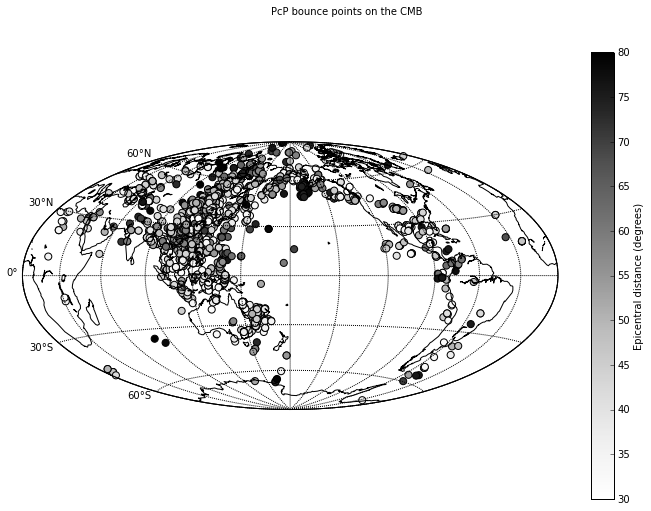

In [12]:
# Plot the bounce points, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.epicentral_distance.values, 
                 cmap=plt.cm.Greys, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('Epicentral distance (degrees)')
fig.suptitle('PcP bounce points on the CMB')
plt.show()    

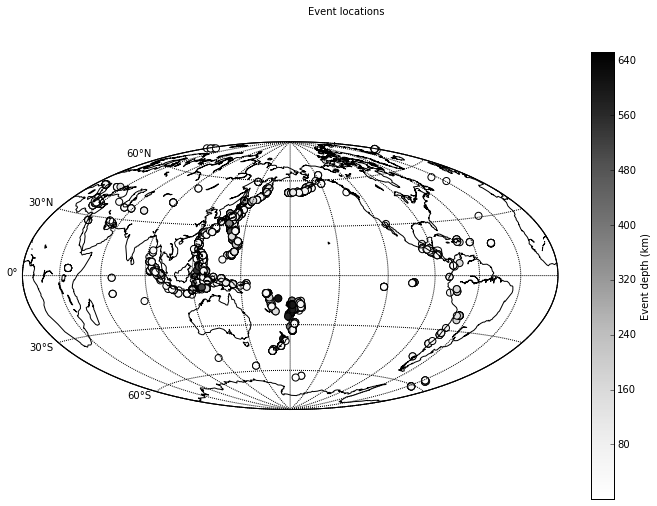

In [13]:
# Plot the events, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.event_lon.values, 
    paired_picks_df.event_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.event_depth.values, 
                 cmap=plt.cm.Greys, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('Event depth (km)')
fig.suptitle('Event locations')
plt.show() 

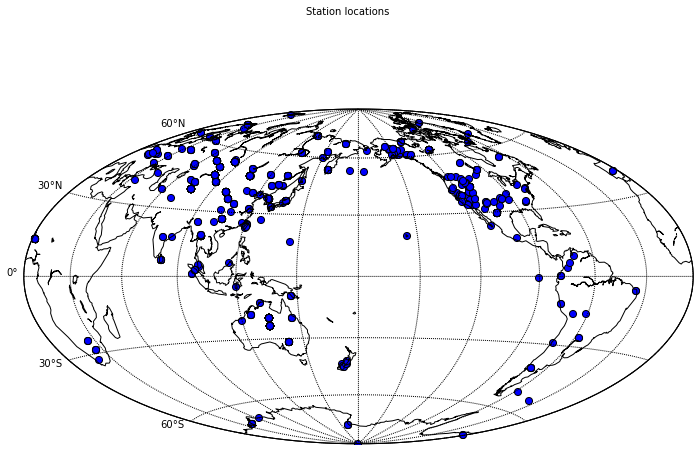

In [14]:
# Plot the stations, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.station_lon.values, 
    paired_picks_df.station_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, s=50)

fig.suptitle('Station locations')
plt.show() 

## Calculate travel time for 1D Earth model
We will store the calculated P and PcP travel time for each event,
then evaluate PcP - P for the data and the model.

In [15]:
# NB - we are using the same taup_model for this

def calc_P(epi, z):
    arrivals = taup_model.get_travel_times(z, epi, phase_list=['P'])
    # Use the last arrival as PcP - to avoid problems with
    # P triplications.
    P_time = arrivals[0].time
    return P_time

def calc_PcP(epi, z):
    arrivals = taup_model.get_travel_times(z, epi, phase_list=['PcP'])
    # Use the last arrival as PcP - to avoid problems with
    # P triplications.
    PcP_time = arrivals[0].time
    return PcP_time

paired_picks_df["P_ttime_calc"] = paired_picks_df.apply(
    lambda row: calc_P(row['epicentral_distance'], row['event_depth']), axis=1)

paired_picks_df["PcP_ttime_calc"] = paired_picks_df.apply(
    lambda row: calc_PcP(row['epicentral_distance'], row['event_depth']), axis=1)

In [21]:
# differential travel times, and residual

paired_picks_df["PcP_P_dtime_calc"] = paired_picks_df.PcP_ttime_calc - \
    paired_picks_df.P_ttime_calc
    
paired_picks_df["PcP_P_dtime"] = paired_picks_df.PcP_ttime - paired_picks_df.P_ttime
    
paired_picks_df["PcP_P_dtime_resid"] = paired_picks_df.PcP_P_dtime - \
    paired_picks_df.PcP_P_dtime_calc

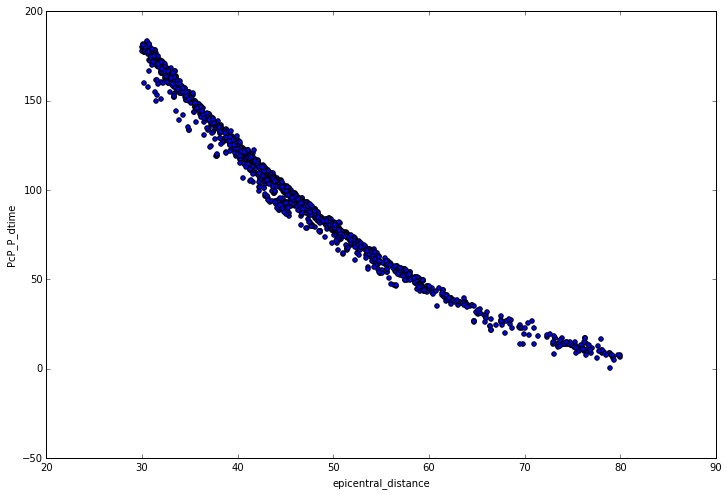

In [26]:
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime')

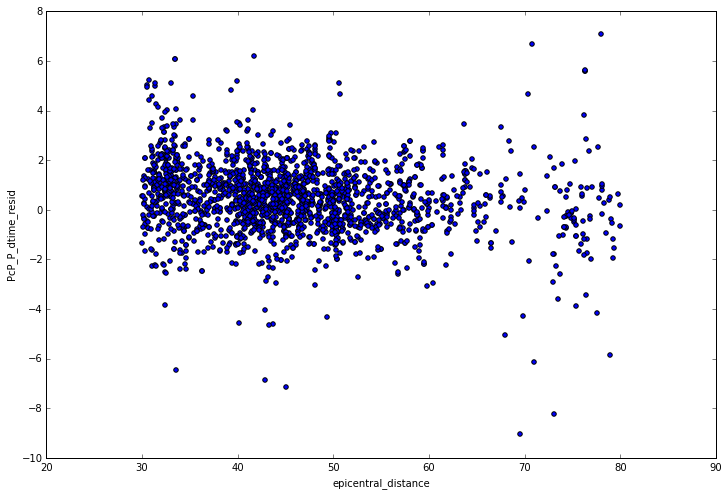

In [22]:
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_resid')

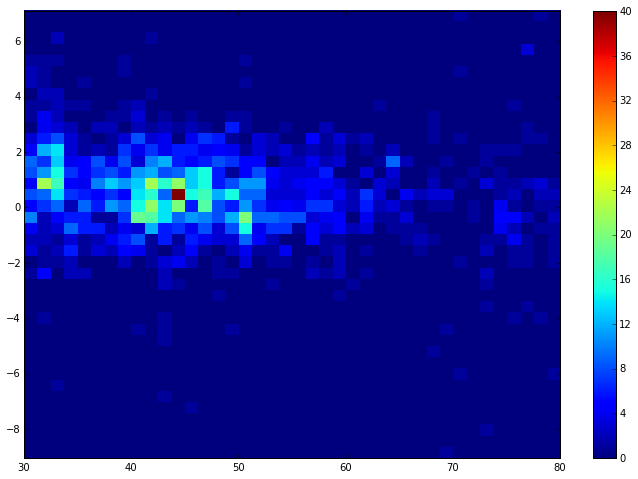

In [28]:
plt.hist2d(paired_picks_df.epicentral_distance.values, 
       paired_picks_df.PcP_P_dtime_resid.values, 
       bins=40)
plt.colorbar()
plt.show()

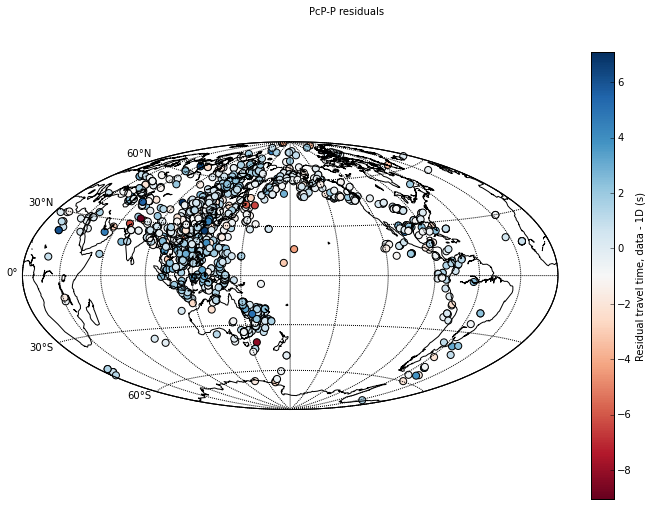

In [25]:
# Plot the bounce points, so 
# we can see where we have data

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_P_dtime_resid.values, 
                 cmap=plt.cm.RdBu, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('Residual travel time, data - 1D (s)')
fig.suptitle('PcP-P residuals')
plt.show()

## Ellipticity correction
For this we are stuck with a wrapper around
the Fortran code. At some point somebody could
code up the raypath integrals...

In [31]:
# We need the event -> station azimuth. Assume elliptical 
# earth for this, but the difference is small (much smaller
# than what comes from the main ellipticity correction). We 
# can do this with geographiclib 

ellipsoid=geod.Geodesic.WGS84

def get_azimuth(source_latitude_in_deg, source_longitude_in_deg,
                station_latitude_in_deg, station_longitude_in_deg):
    
    g = ellipsoid.Inverse(source_latitude_in_deg, source_longitude_in_deg,
                              station_latitude_in_deg, station_longitude_in_deg)
    return g['azi1']

paired_picks_df["azimuth"] = paired_picks_df.apply(
    lambda row: get_azimuth(row['event_lat'], 
                            row['event_lon'], 
                            row['station_lat'],
                            row['station_lon']), axis=1)


In [32]:
# Setup direct access tables
ellippy.ellip_setup()

paired_picks_df["P_ellip_corr"] = paired_picks_df.apply(
    lambda row: ellippy.ellip_correct(row['event_lat'], 
                                      row['event_depth'], 
                                      row['azimuth'],
                                      row['epicentral_distance'], 'P'), axis=1)

paired_picks_df["PcP_ellip_corr"] = paired_picks_df.apply(
    lambda row: ellippy.ellip_correct(row['event_lat'], 
                                      row['event_depth'], 
                                      row['azimuth'],
                                      row['epicentral_distance'], 'PcP'), axis=1)

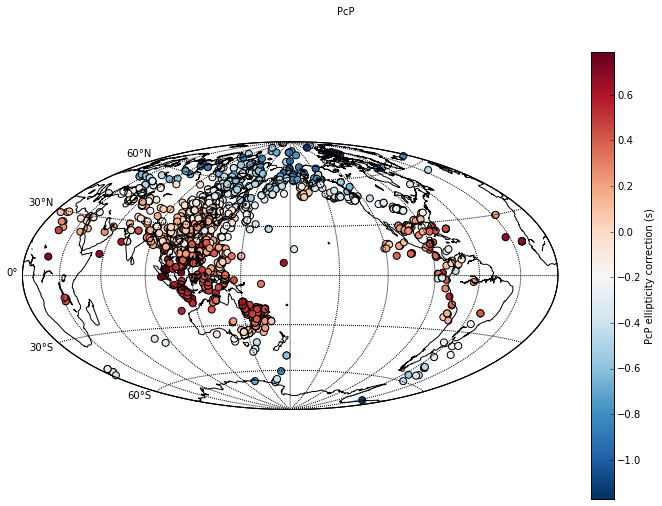

In [48]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_ellip_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP ellipticity correction (s)')
fig.suptitle('PcP')
plt.show()

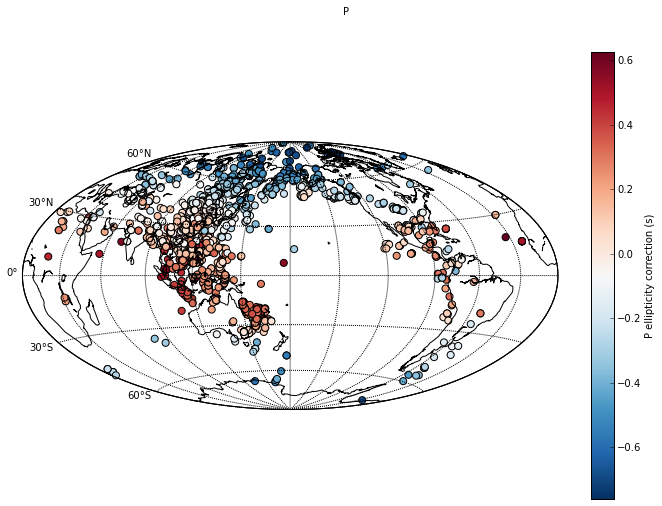

In [49]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.P_ellip_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('P ellipticity correction (s)')
fig.suptitle('P')
plt.show()

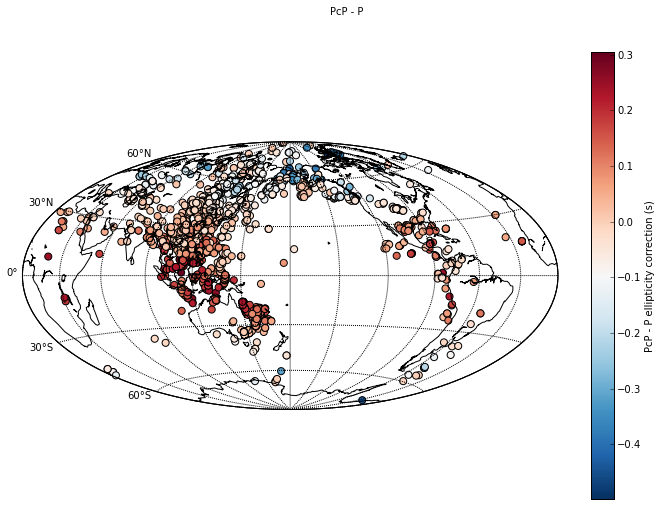

In [50]:

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_ellip_corr.values - 
                    paired_picks_df.P_ellip_corr.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P ellipticity correction (s)')
fig.suptitle('PcP - P')
plt.show()

## Tomographic correction

In [36]:
# Setup the tomography model - you can only do this once
# (Fortran limitation)
corrector = tomocorr2.TomographicCorrection('../tools/tomocorr/ak135.1D_vp', 
                                            '../tools/tomocorr/vdh3D_1999', 
                                            ellipsoid=geod.Geodesic(a=6371000.0, f=0))

In [43]:
# Calculate tomoraphic corrections - this takes a few mins...
paired_picks_df["P_tomo_corr"] = paired_picks_df.apply(
    lambda row: corrector.calculate(row['event_lat'],
                                    row['event_lon'],
                                    row['event_depth'],
                                    row['station_lat'],
                                    row['station_lon'], ['P'])[0], axis=1)

paired_picks_df["PcP_tomo_corr"] = paired_picks_df.apply(
    lambda row: corrector.calculate(row['event_lat'],
                                    row['event_lon'],
                                    row['event_depth'],
                                    row['station_lat'],
                                    row['station_lon'], ['PcP'])[0], axis=1)

In [44]:
# It turns out we have one bogus (probably)
# path, giving ~20 s of P and PcP correction.
# The bounce point is off N Japan...
print paired_picks_df[(paired_picks_df.PcP_tomo_corr < -10.0)]

# We will remove this:
paired_picks_df = paired_picks_df[(paired_picks_df.PcP_tomo_corr > -10.0)]

Empty DataFrame
Columns: [eventid, P_datetime, station_lon, reporter, PcP_datetime, epicentral_distance, station_elev, event_lat, station, backazimuth, event_depth, event_lon, event_datetime, station_lat, PcP_ttime, P_ttime, CMB_bounce_lat, CMB_bounce_lon, P_ttime_calc, PcP_ttime_calc, PcP_P_dtime_calc, PcP_P_dtime, PcP_P_dtime_resid, azimuth, P_ellip_corr, PcP_ellip_corr, P_tomo_corr, PcP_tomo_corr]
Index: []

[0 rows x 28 columns]


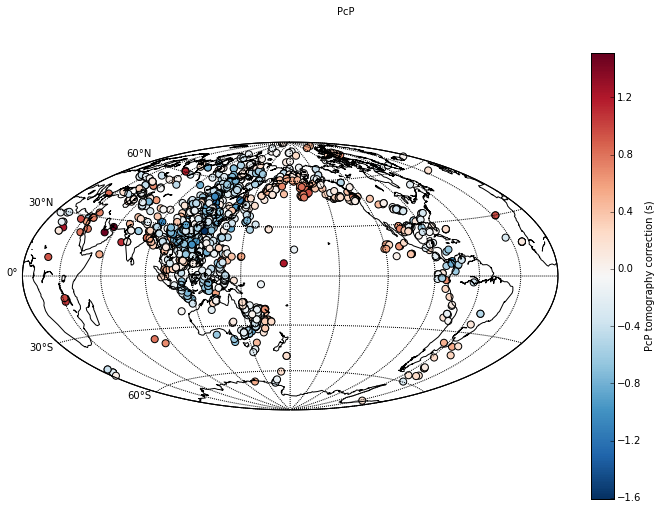

In [51]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.PcP_tomo_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP tomography correction (s)')
fig.suptitle('PcP')
plt.show()

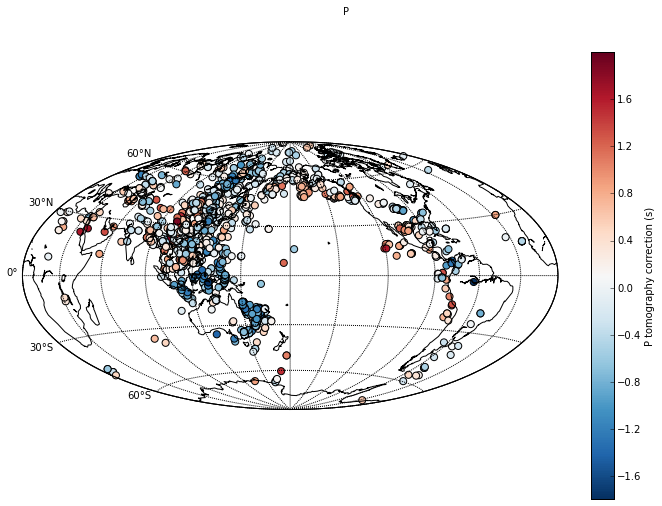

In [52]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=paired_picks_df.P_tomo_corr.values, 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('P tomography correction (s)')
fig.suptitle('P')
plt.show()

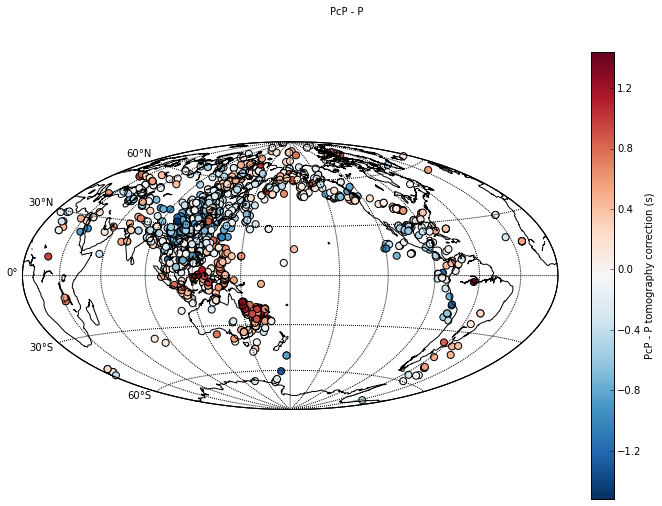

In [53]:
# Plot the corrections

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_tomo_corr.values -
                    paired_picks_df.P_tomo_corr.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P tomography correction (s)')
fig.suptitle('PcP - P')
plt.show()

## Apply the corrections
Add the corrections to the data to remove
the ellipticity and mantle structure. This
Should leave something we can use to invert
for CMB topography and crustal structure.

In [54]:
paired_picks_df["P_ttime_corrected"] = paired_picks_df.P_ttime + \
    paired_picks_df.P_tomo_corr + paired_picks_df.P_ellip_corr
    
paired_picks_df["PcP_ttime_corrected"] = paired_picks_df.PcP_ttime + \
    paired_picks_df.PcP_tomo_corr + paired_picks_df.PcP_ellip_corr

In [55]:
paired_picks_df["PcP_P_dtime_corrected"] = paired_picks_df.PcP_ttime_corrected - \
    paired_picks_df.P_ttime_corrected
    
paired_picks_df["PcP_P_dtime_corrected_resid"] = paired_picks_df.PcP_P_dtime_corrected - \
    paired_picks_df.PcP_P_dtime_calc

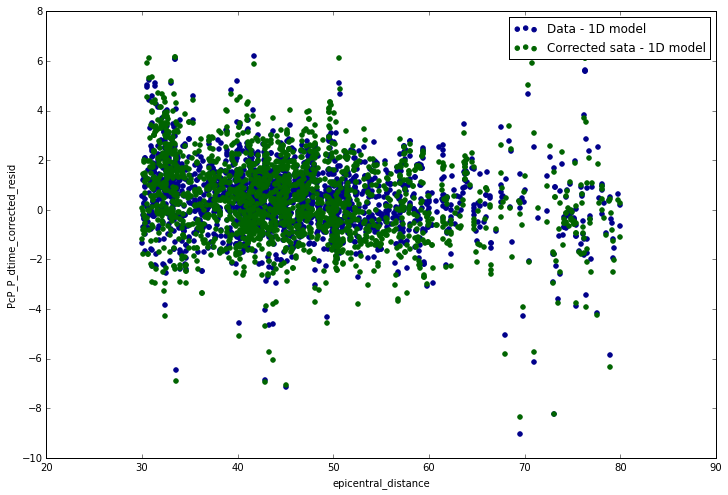

In [56]:
ax = paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_resid', 
                          color='DarkBlue', label='Data - 1D model')
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_P_dtime_corrected_resid', 
                          color='DarkGreen', label='Corrected data - 1D model', ax=ax)

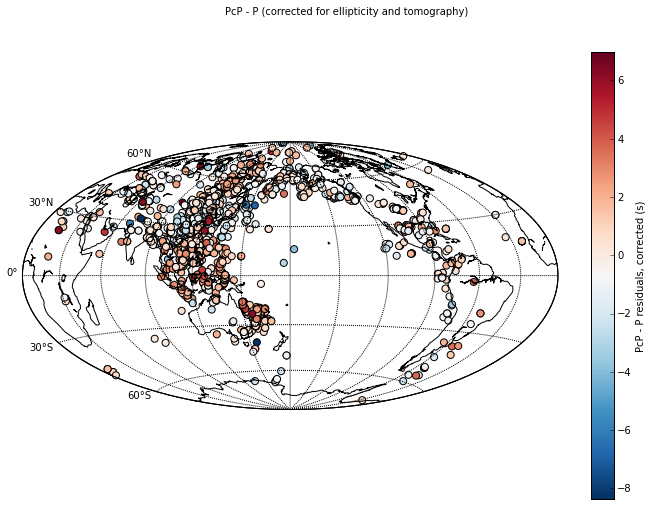

In [58]:
# Plot the residual

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_P_dtime_corrected_resid.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P residuals, corrected (s)')
fig.suptitle('PcP - P (corrected for ellipticity and tomography)')
plt.show()

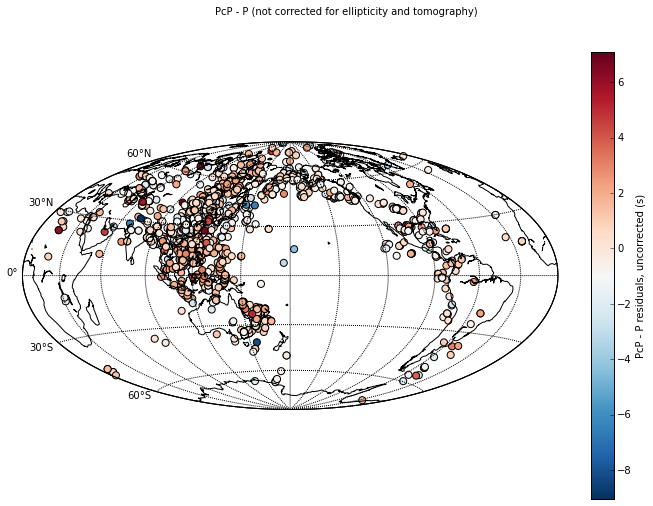

In [59]:
# Plot the residual

fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.PcP_P_dtime_resid.values), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('PcP - P residuals, uncorrected (s)')
fig.suptitle('PcP - P (not corrected for ellipticity and tomography)')
plt.show()

## Store the results
So we can do additional analysis

In [82]:
paired_picks_df.to_pickle('processed_data.pkl')